### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Tercer tarea programada 2022-I

Profesora: María Auxiliadora Mora


# Estudiantes
Roy Chavarría Garita - 2018034199 \
Jonder Hernández Gutiérrez - 2018203660




# Sección 1. Redes neuronales convolucionales.

## Problema

Realizar el entrenamiento de un modelo utilizando redes convolucionales utilizando imágenes de animales para poder predecir a cuál animal corresponde dicha imagen. Se desea que dada una imagen de un animal dentro del conjunto de datos, de una buena predicción de cuál animal es.


## Objetivo
1. Poner en práctica habilidades de investigación y documentación de resultados. 
2. Aplicar el conocimiento teórico sobre aprendizaje profundo en la implementación de
un ejemplo aplicado a la clasificación de imágenes.
3. Experimentar con el flujo completo de trabajo requerido en proyectos de
aprendizaje automático para realizar análisis de sentimientos a partir de datos en
lenguaje natural.
4. Fortalecer capacidades en los estudiantes en el uso de bibliotecas de aprendizaje
automático como PyTorch y otras.

## Descripción de datos
Es un conjunto de carpetas en donde cada carpeta tiene imágenes de un animal determinado. En total son 90 animales de varios reinos. Cada carpeta tiene varias imágenes con diferentes entornos que contiene al animal. Este conjunto de datos se puede descargar del siguiente enlace: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

In [1]:
#Instalo si no existe la librería matplotlib, torch y torchvision
!pip install numpy matplotlib torch torchvision

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
#Bibliotecas
import torch
import torchvision

# Para graficar
%matplotlib inline
import matplotlib.pyplot as plt

#Bibliotecas generales
import torchvision.transforms as transforms

# Redes neuronales
import torch.nn as nn
import torch.nn.functional as F

# Pérdida y optimización
import torch.optim as optim

#Para los datos del modelo
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import random_split
import numpy as np

## Cargar, normalizar y explorar los datos

In [3]:
# Carga de los datos divididos en datos de entrenamiento y validación.
# Normaliza la imagen pasa de una imagen normal a una donde se nota más las lineas
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

#Conjunto de datos que contienen las imágenes de los animales
dataset = ImageFolder('data/animals', transform=transform)
#Nombre de las clases o animales
classes = dataset.classes
data_loader = DataLoader(dataset, batch_size=20, shuffle=True)

In [4]:
# Para mostar las dimensiones de la imagen
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


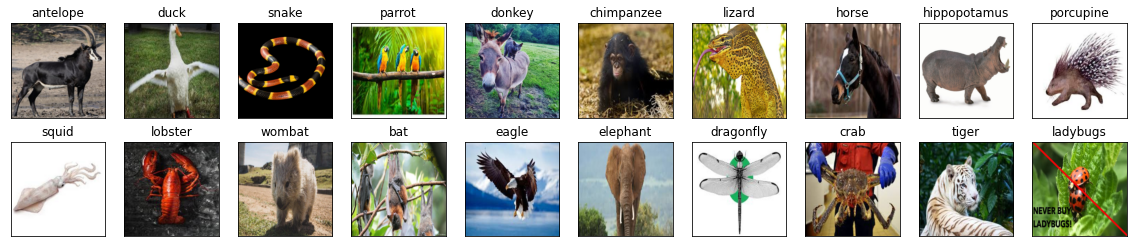

In [5]:
#Muestro mis primeras 20 imágenes dentro de mi datos
def imshow(img):
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
dataiter = iter(data_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Cálculo de registros por clase

In [6]:
#Calculamos la cantidad de registros por clase para saber si están balanceadas
labels = {}
for label in classes:
    labels[label] = 0
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
for data in data_loader:
    img, label = data
    labels[classes[label.item()]] += 1
print(labels)

{'antelope': 60, 'badger': 60, 'bat': 60, 'bear': 60, 'bee': 60, 'beetle': 60, 'bison': 60, 'boar': 60, 'butterfly': 60, 'cat': 60, 'caterpillar': 60, 'chimpanzee': 60, 'cockroach': 60, 'cow': 60, 'coyote': 60, 'crab': 60, 'crow': 60, 'deer': 60, 'dog': 60, 'dolphin': 60, 'donkey': 60, 'dragonfly': 60, 'duck': 60, 'eagle': 60, 'elephant': 60, 'flamingo': 60, 'fly': 60, 'fox': 60, 'goat': 60, 'goldfish': 60, 'goose': 60, 'gorilla': 60, 'grasshopper': 60, 'hamster': 60, 'hare': 60, 'hedgehog': 60, 'hippopotamus': 60, 'hornbill': 60, 'horse': 60, 'hummingbird': 60, 'hyena': 60, 'jellyfish': 60, 'kangaroo': 60, 'koala': 60, 'ladybugs': 60, 'leopard': 60, 'lion': 60, 'lizard': 60, 'lobster': 60, 'mosquito': 60, 'moth': 60, 'mouse': 60, 'octopus': 60, 'okapi': 60, 'orangutan': 60, 'otter': 60, 'owl': 60, 'ox': 60, 'oyster': 60, 'panda': 60, 'parrot': 60, 'pelecaniformes': 60, 'penguin': 60, 'pig': 60, 'pigeon': 60, 'porcupine': 60, 'possum': 60, 'raccoon': 60, 'rat': 60, 'reindeer': 60, 'rhi

## Definición de red convulucional

In [7]:
# Crear el modelo de aprendizaje profundo, se crea una clase 
# que envuelve la clase nn.Module 
class Net(nn.Module):
    def __init__(self):
        # Función para definir e inicializar la red.
        super(Net, self).__init__()
        
        #capa convolucional
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size...
        self.conv1 = nn.Conv2d(3, 6, 3)
        
        #torch.nn.MaxPool2d(kernel_size, stride,...        
        self.pool = nn.MaxPool2d(2, 2) 
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size...
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        #Capas perceptrón del modelo
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 90)
        
    def forward(self, x):
        # Aplica el modelo a los datos de entrada.
        # :param
        #   x : datos de la imagen a procesar.
        
        #Pase de la entrada por todas las capas de la red.
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model = Net()

## Definición de hiper-parámetros 

Se utiliza la función de pérdida de entropía cruzada y optimización por descenso de gradiente estocástico (Stochastic Gradient Descent - SGD).

In [8]:
import torch.nn.functional as F

#Funcion de loss
loss_function = F.cross_entropy

#Funcipon de optimización
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Datos de pruebas y validación

Se separa las muestras en datos de entrenamiento y validación

In [9]:
#Defino un tamaño de batch
batch_size = 10

#len(dataset)*0.7+1 y len(dataset)*0.3+1  esto con la funcion piso
#train_set, test_set = random_split(dataset, [3780, 1620])
train_set = ImageFolder('data/animals', transform=transform)
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)

#len(train_set)*0.7+1 y len(train_set)*0.3+1  esto con la funcion piso
#train_set, valid_set = random_split(train_set, [2646, 1134])

#Datos de entrenamiento
test_set = ImageFolder('data/animals', transform=transform)
test_loader = DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

#print(len(train_loader))

In [10]:
#guardo para mostar la gráfica de error
acc_l = []
loss_l = []
val_acc_l = []
val_loss_l = []

In [11]:
from sklearn.metrics import mean_squared_error
#Esta funcion me ayuda a extraer datos para poder graficar la curva de error
#Esta funcion me ayuda a extraer datos para poder graficar la curva de error
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, l in valid_dl:
        y = l.long()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

## Entreno el modelo

In [12]:
loss_values = []

def train_model(model,numEpoch, train_loader, loss_function, optimizer):
    # cantidad de ciclos de entrenamiento o épocas
    total = len(train_loader)
    for epoch in range(numEpoch):  
        running_loss = 0.0
        total = 0
        for i, data in enumerate(train_loader,0):
            y = data[1].long()
            # obtener los datos de entrada; 
            # data es una lista de la forma [inputs, labels]
            inputs, labels = data

            # inicializar los parámetros del gradiente.
            optimizer.zero_grad()

            # Se realizan las predicciones con el modelo. 
            # Este código ejecuta el forward de las entradas.
            outputs = model(inputs)

            # Se calcula la pérdida utilizando Cross Entropy Loss
            loss = loss_function(outputs, labels)       
            loss.backward()

            #El optimizador realiza las actualizaciones a través del método step().
            optimizer.step()
            #print(i)
            # imprimir estadisticas
            running_loss += loss.item()
            loss_values.append(running_loss)
            total += y.shape[0]
            if i % 100 == 0:    # imprimir mensaje cada 100 mini-batches
                print('[%d, %5d] pérdida: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
                
        #Guardo los datos para graficar la curva de error
        val_loss, val_acc, val_rmse = validation_metrics(model, test_loader)
        
        #guardo datos para graficarlos en curva de error
        val_loss_l.append(val_loss)
        val_acc_l.append(val_acc)
        loss_l.append(running_loss / 100)
        acc_l.append(val_rmse)

    print('Fin del entrenamiento')


In [13]:
train_model(model,10, train_loader, loss_function, optimizer)
#print(loss_values)

[1,     1] pérdida: 0.045
[1,   101] pérdida: 4.501
[1,   201] pérdida: 4.501
[1,   301] pérdida: 4.502
[1,   401] pérdida: 4.503
[1,   501] pérdida: 4.498
[2,     1] pérdida: 0.045
[2,   101] pérdida: 4.496
[2,   201] pérdida: 4.494
[2,   301] pérdida: 4.489
[2,   401] pérdida: 4.479
[2,   501] pérdida: 4.484
[3,     1] pérdida: 0.044
[3,   101] pérdida: 4.452
[3,   201] pérdida: 4.437
[3,   301] pérdida: 4.408
[3,   401] pérdida: 4.360
[3,   501] pérdida: 4.319
[4,     1] pérdida: 0.044
[4,   101] pérdida: 4.249
[4,   201] pérdida: 4.214
[4,   301] pérdida: 4.186
[4,   401] pérdida: 4.194
[4,   501] pérdida: 4.157
[5,     1] pérdida: 0.039
[5,   101] pérdida: 3.994
[5,   201] pérdida: 4.042
[5,   301] pérdida: 4.068
[5,   401] pérdida: 4.004
[5,   501] pérdida: 4.015
[6,     1] pérdida: 0.043
[6,   101] pérdida: 3.871
[6,   201] pérdida: 3.868
[6,   301] pérdida: 3.906
[6,   401] pérdida: 3.864
[6,   501] pérdida: 3.867
[7,     1] pérdida: 0.034
[7,   101] pérdida: 3.669
[7,   201] p

## Evaluación del modelo con métricas

In [14]:
#Acurrancy
# Se toma todos los datos de prueba y se verifica si el modelo realiza
# bien la predicción para cada uno. 

#Cantidad de imágenes clasificadas correctamente.
correct = 0

#Imágenes totales
total = 0

with torch.no_grad():
    for data in test_loader:
        # Datos de las imágenes y etiquetas
        images, labels = data
        
        # Forward de las imágenes en el modelo.
        outputs = model(images)
        
        # Clase a la que pertece cada imagen
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Exactitud de la red en las 10000 imágenes de prueba: %d %%' % (
    100 * correct / total))

Exactitud de la red en las 10000 imágenes de prueba: 46 %


## Matriz de confusión

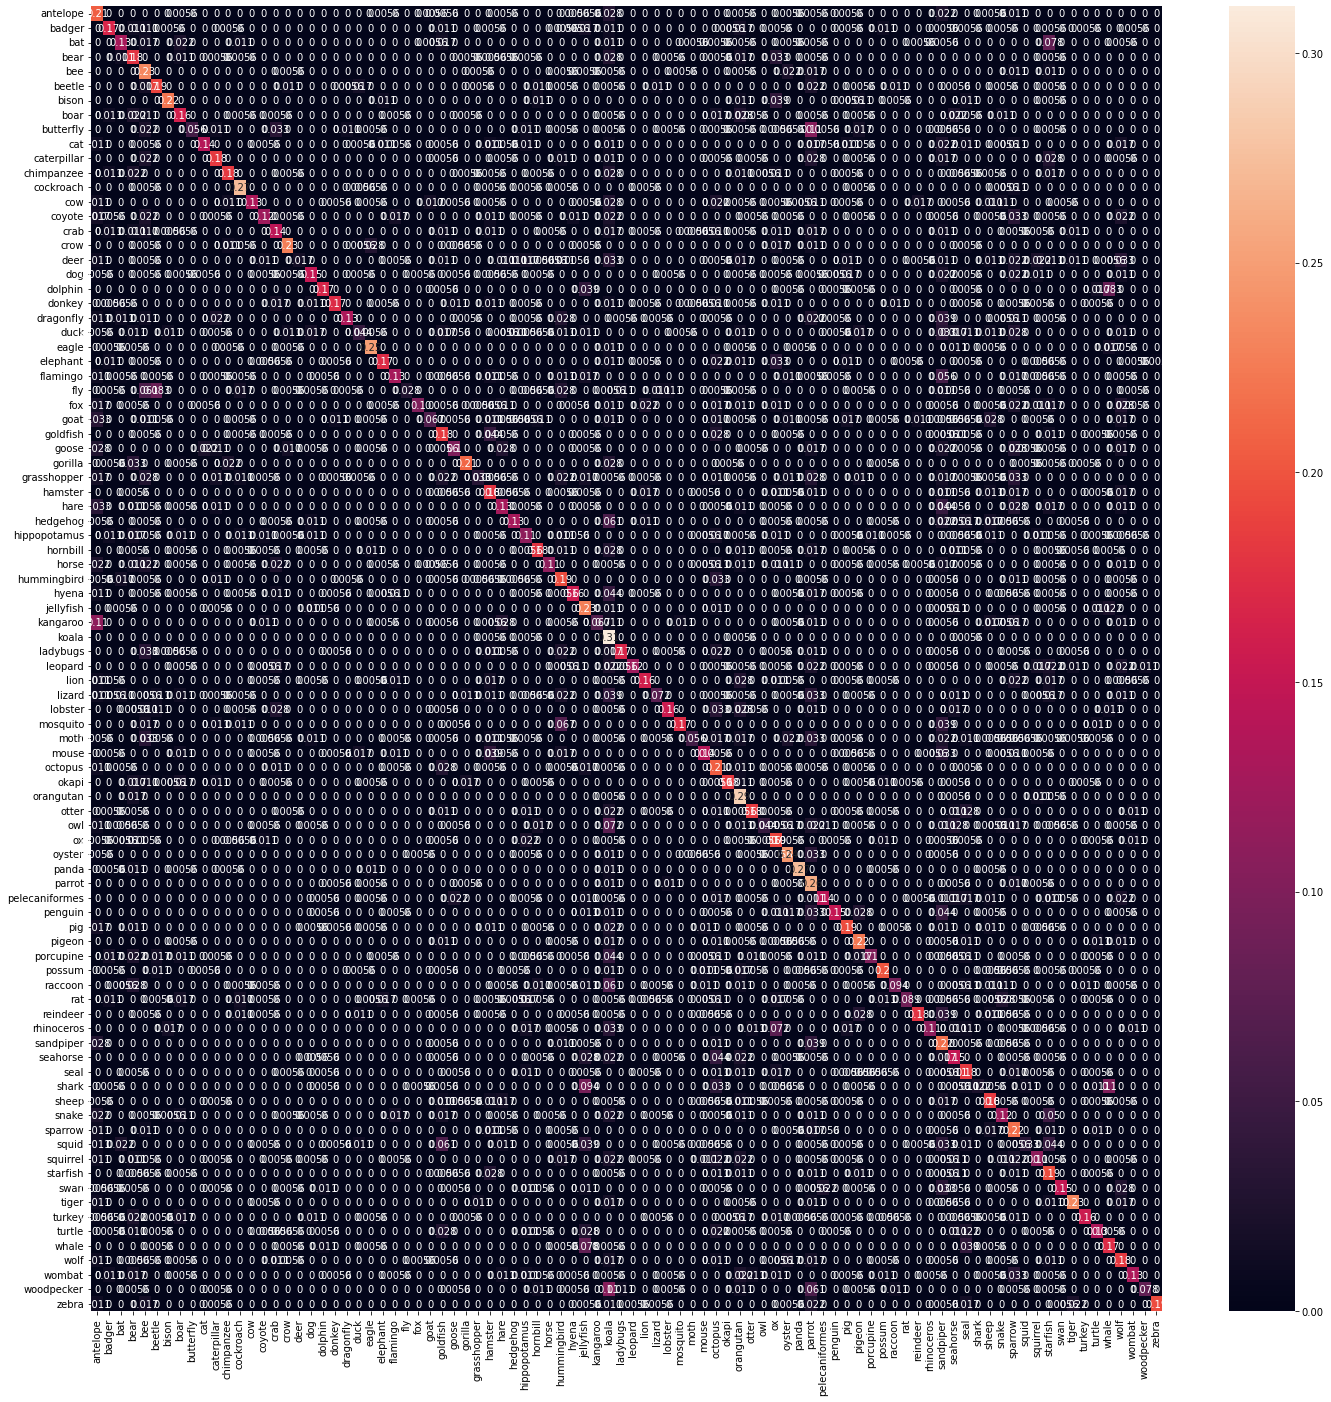

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *30, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (24,24))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

Como se puede observar en la matriz, la mayoría de filas o clases están rellenas con ceros, esto significa que el sistema no tiene muchos problemas al distinguir un animal o clase. Con esta matriz podemos deducir que la red casi no se confunde entre las diferentes clases. En los cuadros que si hay números, aparte de la diagonal, eso significa que la red confundió un animal con otro.

## Gráfica de curva de error

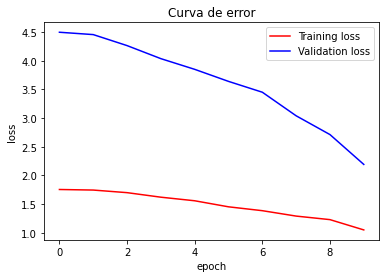

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

loss = loss_l
val_loss = val_loss_l

epochs = range(len(acc_l))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Curva de error')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

Se puede observar que conforme el algoritmo de entrenamiento va avanzando, la red tiene menos problemas en aprender. Como la gráfica muestra que esa variación se diminuyó al final pero no es suficiente por lo que debo aumentar el número de pochs.

## Mejoras y cambios

- Para mejorar el resultado a la predicción se ajustaron los epochs a 10 y se minimizó el tamaño de la imagen para poder realizar los cálculos más rápidos.
- Otra mejora que se puede realizar es añadir la rotación aleatoria de imágenes.
- Se mejorará el sistema utilizando transfering learning en donde tomamos el modelo ya entrenado y le modificamos la última capa ajustandola a nuestro problema.

## Aplicación de Cambios (Técnica de tranferencia)



In [17]:
from torchvision import models
#Tecnica de transferencia para una red neuronal
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features,90)
                                   
    def forward(self, image):
        output = self.resnet(image)
        return output

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Classifier().to(device)

criterion2 = nn.CrossEntropyLoss()
params = model.resnet.fc.parameters()
optimizer2 = optim.Adam(params, lr=0.003)
train_model(model,2, train_loader, criterion2, optimizer2)

[1,     1] pérdida: 0.051
[1,   101] pérdida: 3.794
[1,   201] pérdida: 1.519
[1,   301] pérdida: 1.075
[1,   401] pérdida: 0.964
[1,   501] pérdida: 0.869
[2,     1] pérdida: 0.003
[2,   101] pérdida: 0.401
[2,   201] pérdida: 0.310
[2,   301] pérdida: 0.366
[2,   401] pérdida: 0.348
[2,   501] pérdida: 0.326
Fin del entrenamiento


In [19]:
#funcion para calcular el acurrancy de nuestro nuevo modelo
def global_accuracy(model, test_loader):
    correct = 0
    total = 0
    model.to("cpu")
    dataiter = iter(test_loader)
    with torch.no_grad():
        for data in dataiter:
            img, label = data
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    print(f"Accuracy: {100 * correct / total}")

In [34]:
# Observamos que tanto mejoró el entrenamiento calculando el acurrancy
global_accuracy(model, test_loader)

Accuracy: 96.94444444444444


## Aplicación de Cambios (RandomRotation y Flip)


In [54]:
transform2 = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(), #Agrego voltear imagen
                                transforms.RandomRotation(10),     #Agrego rotación aleatoria
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])
#Creo un nuevo modelo
#model2 = Net()
batch_size2 = 3000
#Conjunto de datos que contienen las imágenes de los animales
datos = ImageFolder('data/animals', transform=transform2)
test_loader2 = DataLoader(datos, batch_size2, shuffle=True, num_workers=2)
train_loader2 = DataLoader(datos, batch_size2, shuffle=True, num_workers=2)

In [55]:
#Funcion de loss
loss_function2 = F.cross_entropy

#Funcipon de optimización
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#entreno el nuevo modelo
train_model(model, 2, train_loader2, loss_function2, optimizer2)

In [ ]:
# Observamos que tanto mejoró el entrenamiento calculando el acurrancy
global_accuracy(model2, test_loader2)

# Conclusiones
- Se puede mejorar el entrenamiento de una red convulusional agregando más opciones al transforms, como por ejemplo rotaciones aleatorias de la imagen

- El tamaño de la imagen mejora la velocidad del algoritmo pero no mejora tanto la predicción.

- Entrenar una red para predecir imágenes consume mucha memoria y recursos, por lo que se debe utilizar los parámetros adecuados para mejorar la velocidad.

- Es recomendable guardar el modelo para no tener que estar entrenandolo cada vez que se vaya a utilizar. Guardarlo no solo nos sirve para utilizarlo sino también para mejorarlo como se hizo anterioromente con transfering learning

## Referencias

- Cómo aplicar una CNN de PyTorch a sus imágenes. manualestutor. (2022). Retrieved 17 May 2022, from
https://manualestutor.com/aprendizaje-automatico/como-aplicar-una-cnn-de-pytorch-a-sus-imagenes/.
- Clasificación de imágenes en Pytorch | ENTRENA EN LA NUBE. The Machine Learners. (2022). Retrieved 17 May 2022, from https://www.themachinelearners.com/clasificacion-imagenes-pytorch/.
- How to create a confusion matrix in PyTorch. Medium. (2022). Retrieved 17 May 2022, from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7.
- Animal Image Dataset (90 Different Animals). Kaggle.com. (2022). Retrieved 17 May 2022, from https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals.
- animal-image-classifications/I_notebook.ipynb at master · imamun93/animal-image-classifications. GitHub. (2022). Retrieved 18 May 2022, from https://github.com/imamun93/animal-image-classifications/blob/master/I_notebook.ipynb.